### NAIVE BAYES SPAM FILTER

#### CMSC 197 Machine Problem 3
Manejo, Kzlyr Shaira
Github link: https://github.com/kazeulo/CMSC197-Machine-Learning.git

In [1]:
# standard libraries 
import numpy as np 
import pandas as pd

# for visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# libraries for preprocessing
import os
import email
import re
import codecs
from collections import Counter  # for getting frequencies of unique words

# for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

<b>Preprocessing</b>

For this part, we will prepare the data set by organizing it, cleaning the email contents, and extracting relevant features.

In [2]:
# load stop words and store them into a list
with open("stop_words.txt","r") as f:
    stop_words = f.read().splitlines()
stop_words

['a',
 'able',
 'about',
 'above',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'added',
 'adj',
 'adopted',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'again',
 'against',
 'ah',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apparently',
 'approximately',
 'are',
 'aren',
 'arent',
 'arise',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'at',
 'auth',
 'available',
 'away',
 'awfully',
 'b',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'begin',
 'beginning',
 'beginnings',
 'begins',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'biol',
 'both',
 'brief',
 'briefly',
 'but',
 'by',
 'c',
 'ca',
 'came',


In [3]:
# initializing dictionaries to store paths and labels
labels_dict = {'file_path':[], 'label':[]}

# read the file for labels 
with open("labels") as f:
    for line in f:
        val, key = line.split()
        labels_dict['file_path'].append(key.strip())
        labels_dict['label'].append(0 if val == 'ham' else 1)

# convert to dataframe
df_labels = pd.DataFrame.from_dict(labels_dict)
df_labels

,file_path,label
0,../data/000/000,0
1,../data/000/001,1
2,../data/000/002,1
3,../data/000/003,0
4,../data/000/004,1
...,...,...
37817,../data/126/017,1
37818,../data/126/018,1
37819,../data/126/019,1
37820,../data/126/020,1


In [4]:
# function to clean the messages/emails
def clean_msg(message):
    words = []
    for word in message.split():
        # remove HTML tags, special characters, and stop words
        temp = re.sub('<[^<>]+>', '', word)  
        temp = re.sub('[^a-zA-Z]', '', temp) 
        
        # check non-empty and not a stop word
        if temp and temp.lower() not in stop_words: 
            
            # convert to lowercase since our stop words are in lowercase
            words.append(temp.lower())  
            
    return words

In [5]:
# here, we clean the messages and merged them with the df_labels to create the main dataframe of our dataset
# initialize a list to store cleaned messages
cleaned_messages = []

# path to the directory containing the email files (replace with your actual path)
email_directory = "dataset/data"

# loop through each file path in the df_labels dataframe
for index, row in df_labels.iterrows():
    file_path = os.path.join(email_directory, row['file_path'])
    
    # read and parse the email
    with codecs.open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        msg = email.message_from_file(f)
        
        # extract the email body
        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain':
                    body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                    break
        else:
            body = msg.get_payload(decode=True).decode('utf-8', errors='ignore')

    # clean the message using the function above
    cleaned_message = clean_msg(body)
    cleaned_messages.append(' '.join(cleaned_message))  # join words back to a string to form the message

# add the cleaned messages to the dataframe 
df_labels['cleaned_message'] = cleaned_messages

df_labels.head()

,file_path,label,cleaned_message
0,../data/000/000,0,mailing list queried weeks ago running set arc...
1,../data/000/001,1,luxury watches buy rolex rolex cartier bvlgari...
2,../data/000/002,1,academic qualifications prestigious nonacc red...
3,../data/000/003,0,greetings verify subscription planfans list ch...
4,../data/000/004,1,chauncey conferred luscious continued tonsillitis


In [6]:
# rename df_labels to df_main to avoid confusion
df_main = df_labels.copy()

# now this is our processed dataset
df_main

,file_path,label,cleaned_message
0,../data/000/000,0,mailing list queried weeks ago running set arc...
1,../data/000/001,1,luxury watches buy rolex rolex cartier bvlgari...
2,../data/000/002,1,academic qualifications prestigious nonacc red...
3,../data/000/003,0,greetings verify subscription planfans list ch...
4,../data/000/004,1,chauncey conferred luscious continued tonsillitis
...,...,...,...
37817,../data/126/017,1,great news expec ted infinex ventures infx pri...
37818,../data/126/018,1,oil sector going crazy weekly gift kkpt thing ...
37819,../data/126/019,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,../data/126/020,1,prosperous future increased money earning powe...


<b>Preparing the training and testing sets.</b>

For this, we will use folders 000-070 as train set and folders 071-126 as test set.

In [7]:
# test set
df_test = df_main[df_main['file_path'] >= '../data/071']
print("Testing set")
df_test.head()

Testing set


,file_path,label,cleaned_message
21300,../data/071/000,1,hesitantly derive perverse satisfaction clodho...
21301,../data/071/001,0,things perform experiment display will remain ...
21302,../data/071/002,1,best offer month viggra ci ialis vaiium xa naa...
21303,../data/071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...
21304,../data/071/004,1,special offer adobe video collection adobe pre...


In [8]:
# general train set
df_train = df_main[df_main['file_path'] < '../data/071']

# for train set of spam
df_train_spam = df_train[df_train['label'] == 1]
df_train_spam = df_train_spam.reset_index()

print("Spam training set")
df_train_spam

Spam training set


,index,file_path,label,cleaned_message
0,1,../data/000/001,1,luxury watches buy rolex rolex cartier bvlgari...
1,2,../data/000/002,1,academic qualifications prestigious nonacc red...
2,4,../data/000/004,1,chauncey conferred luscious continued tonsillitis
3,7,../data/000/007,1,nbc today body diet beaches magazines hollywoo...
4,8,../data/000/008,1,oil sector going crazy weekly gift kkpt thing ...
...,...,...,...,...
13772,21294,../data/070/294,1,txtadd
13773,21295,../data/070/295,1,btijclnab binpqnejgmb httpgethighbizez bldb xi...
13774,21296,../data/070/296,1,special offer adobe video collection adobe pre...
13775,21297,../data/070/297,1,doctype html public wcdtd html transitionalen ...


In [9]:
# for train set of ham
df_train_ham = df_train[df_train['label'] == 0]
df_train_ham = df_train_ham.reset_index()
print("Ham training set")
df_train_ham

Ham training set


,index,file_path,label,cleaned_message
0,0,../data/000/000,0,mailing list queried weeks ago running set arc...
1,3,../data/000/003,0,greetings verify subscription planfans list ch...
2,5,../data/000/005,0,quiet quiet well straw poll plan running
3,6,../data/000/006,0,working departed totally bell labs recommended...
4,10,../data/000/010,0,greetings mass acknowledgement signed planfans...
...,...,...,...,...
7518,21270,../data/070/270,0,equation generate prime numbers equation theor...
7519,21271,../data/070/271,0,equation generate prime numbers equation theor...
7520,21288,../data/070/288,0,dear dmdx users guidance generating dmdx item ...
7521,21293,../data/070/293,0,built handyboard works great testmotor passes ...


<b>Extracting the list of unique words.</b>

We will get the 1000 most common words only or words with highed frequencies/occurences in the dataset

In [10]:
# combine messages from the entire df_train dataset
all_words = []

# process all messages in df_train
for msg in df_train['cleaned_message']:
    all_words.extend(msg.split())

# count occurrences of each word
word_counts = Counter(all_words)

# get the 10,000 most common words and their frequencies
most_common_words = word_counts.most_common(10000)

# convert to a dataframe
df_unique_words = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

df_unique_words

,word,frequency
0,bb,17268
1,td,12030
2,will,11941
3,width,8226
4,size,5363
...,...,...
9995,httpwwwretsiunetptwwwukrnet,21
9996,hrefhttpwwwretsiunetptampwwwukrnetfont,21
9997,emulator,21
9998,caring,21


<b>Creating the feature matrices</b>

For each word in the dictionary, we will traverse through each file and check its occurrence. If the word exist, we will mark the cell with 1, 0 otherwise.

In [11]:
# initialize feature matrices for spam and ham
num_spam = df_train_spam.shape[0]
num_ham = df_train_ham.shape[0]
dimension = 10000

# create an empty matrix
matrix_spam = np.zeros((num_spam, dimension), dtype=int)
matrix_ham = np.zeros((num_ham, dimension), dtype=int)

# create a mapping from words to indices
word_index = {word: i for i, (word, _) in enumerate(most_common_words)}

# function to fill the feature matrix
def fill_feature_matrix(df, matrix, index, column_name):
    for i, message in enumerate(df[column_name]):
        words = set(message.split())  # use a set to avoid duplicate checks
        for word in words:
            if word in index:
                matrix[i, index[word]] = 1  # mark the occurrence of the word, otherwise the value will be 0

In [12]:
# fill the spam feature matrix
fill_feature_matrix(df_train_spam, matrix_spam, word_index, 'cleaned_message')

print("Shape of spam feature matrix:", matrix_spam.shape)
matrix_spam

Shape of spam feature matrix: (13777, 10000)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# fill the ham matrix
fill_feature_matrix(df_train_ham, matrix_ham, word_index, 'cleaned_message')

print("Shape of ham feature matrix:", matrix_ham.shape)
matrix_ham

Shape of ham feature matrix: (7523, 10000)


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<b>Calculating the priors</b>

In [14]:
# compute the prior probabilities for spam and ham
n_ham = len(df_train_ham)       # number of ham emails in training set
n_spam = len(df_train_spam)     # number of spam emails in training set
n_doc = len(df_train)           # number of total emails in training set

p_ham = n_ham / n_doc           # divide number of ham emails over the total emails in training set
p_spam = n_spam / n_doc         # divide the number of spam emails over the total emails in training set

print("p_ham: ", p_ham)
print("p_spam: ", p_spam)

p_ham:  0.3531924882629108
p_spam:  0.6468075117370892


<b>Computing the likelihood of each word.</b>

In [15]:
# calculate probabilities with Laplace smoothing
V = len(df_unique_words)

# count words in ham and spam classes
ham_word_count = np.sum(matrix_ham, axis=0)
spam_word_count = np.sum(matrix_spam, axis=0)

# total words
ham_word_total = np.sum(ham_word_count)
spam_word_total = np.sum(spam_word_count)

# laplace smoothing parameter
a = 1 

# initialize dictionaries to store probabilities
ham_probabilities = {}
spam_probabilities = {}

for i in range(V):
    word = df_unique_words['word'][i]
    
    # P(w_i|ham) = (count(w_i,ham) + a) / (total words in ham + a * V)
    temp_ham = (ham_word_count[i] + a) / (ham_word_total + a * V)
    
    # P(w_i|spam) = (count(w_i,spam) + a) / (total words in spam + a * V)
    temp_spam = (spam_word_count[i] + a) / (spam_word_total + a * V)
    
    # assign probabilities to the respective dictionaries
    ham_probabilities[word] = temp_ham
    spam_probabilities[word] = temp_spam

# create a dataframe to display the probabilities
df_probabilities = pd.DataFrame({
    'Word': df_unique_words['word'],
    'P(w|ham)': [ham_probabilities[word] for word in df_unique_words['word']],
    'P(w|spam)': [spam_probabilities[word] for word in df_unique_words['word']]
})

df_probabilities.head()

,Word,P(w|ham),P(w|spam)
0,bb,0.000048,0.002165
1,td,0.000038,0.001460
2,will,0.006197,0.004816
3,width,0.000180,0.002001
4,size,0.000552,0.002026


<b>Classifying the emails</b>

In [16]:
# function to classify the emails
def classify_emails(email, p_ham, p_spam, p_count_ham, p_count_spam, word_list):
    # initialize the log values of ham and spam with the log of their prior probabilities
    log_p_ham = np.log(p_ham)
    log_p_spam = np.log(p_spam)
    
    # split the cleaned email content into words
    words = email.split() 
    
    for w in words:
        # add the log probability value if the word is in the word list
        if w in word_list:
            log_p_ham += np.log(p_count_ham[w])
            log_p_spam += np.log(p_count_spam[w])
    
    # return 0 if the log probability of ham is greater than spam
    if log_p_ham > log_p_spam:
        return 0  # Ham
    else:
        return 1  # Spam

<b> Testing the Classifier </b>

In [17]:
# initialize lists to store predictions and actual labels
predictions = []
actual_labels = df_test['label'].tolist()  # Get actual labels from the test set

# classify each email in the test set
for message in df_test['cleaned_message']:
    prediction = classify_emails(message, p_ham, p_spam, ham_probabilities, spam_probabilities, df_unique_words['word'].tolist())
    predictions.append(prediction)

In [18]:
# create a dataframe for predictions vs actual labels with file paths and messages
results_df = pd.DataFrame({
    'File Path': df_test['file_path'],
    'Actual Label': actual_labels,
    'Predicted Label': predictions,
    'Cleaned Message': df_test['cleaned_message']
})

results_df

,File Path,Actual Label,Predicted Label,Cleaned Message
21300,../data/071/000,1,1,hesitantly derive perverse satisfaction clodho...
21301,../data/071/001,0,0,things perform experiment display will remain ...
21302,../data/071/002,1,1,best offer month viggra ci ialis vaiium xa naa...
21303,../data/071/003,1,1,de ar wne cr doesnt matter ow real st mmed ia ...
21304,../data/071/004,1,1,special offer adobe video collection adobe pre...
...,...,...,...,...
37817,../data/126/017,1,1,great news expec ted infinex ventures infx pri...
37818,../data/126/018,1,1,oil sector going crazy weekly gift kkpt thing ...
37819,../data/126/019,1,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,../data/126/020,1,1,prosperous future increased money earning powe...


<b>Performance Evaluation</b>

In [21]:
# Calculate evaluation metrics
df_evaluation = results_df.copy()

accuracy = accuracy_score(df_evaluation['Actual Label'], df_evaluation['Predicted Label'])
precision = precision_score(df_evaluation['Actual Label'], df_evaluation['Predicted Label'])
recall = recall_score(df_evaluation['Actual Label'], df_evaluation['Predicted Label'])

# display the results
print("Evaluation Metrics:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Evaluation Metrics:
Accuracy:  0.9306379372957269
Precision:  0.9779883242415542
Recall:  0.9177368657386619


Confusion Matrix:


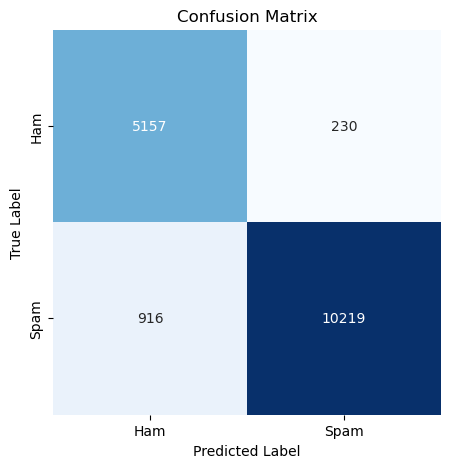

False Positive Rate (FP) - 230
False Negative Rate (FN) - 916
True Positive Rate (TP) - 10219
True Negative Rate (TN) - 5157


In [22]:
# displaying the confusion matrix
conf_matrix = confusion_matrix(df_evaluation['Actual Label'], df_evaluation['Predicted Label'])

print("Confusion Matrix:")

# plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(conf_matrix[0][1])) 
print("False Negative Rate (FN) - {}".format(conf_matrix[1][0])) 
print("True Positive Rate (TP) - {}".format(conf_matrix[1][1])) 
print("True Negative Rate (TN) - {}".format(conf_matrix[0][0])) 

### Results and Discussion 

<b>1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.</b>

Let's try a preprocessing where the stop_words are included. Basically, the steps here are just the same with the previous one, excluding only the stop_words on preprocessing

In [23]:
# clean message function
def clean_msg(message):
    words = []
    for word in message.split():
        # Remove HTML tags, special characters, and stop words
        temp = re.sub('<[^<>]+>', '', word)   
        temp = re.sub('[^a-zA-Z]', '', temp)  

        # we modified this part and remove the condition that the word should not be included in the stop_words
        if temp:  # check non-empty
            words.append(temp.lower()) 
        
    return words

In [24]:
# initializing dictionaries to store paths and labels
labels_dict = {'file_path':[], 'label':[]}

# read the file for labels 
with open("labels") as f:
    for line in f:
        val, key = line.split()
        labels_dict['file_path'].append(key.strip())
        labels_dict['label'].append(0 if val == 'ham' else 1)

# convert to dataframe
df_labels = pd.DataFrame.from_dict(labels_dict)
df_labels

,file_path,label
0,../data/000/000,0
1,../data/000/001,1
2,../data/000/002,1
3,../data/000/003,0
4,../data/000/004,1
...,...,...
37817,../data/126/017,1
37818,../data/126/018,1
37819,../data/126/019,1
37820,../data/126/020,1


In [25]:
# clean the messages and merged them with the df_labels to create our dataframe
# initialize a list to store cleaned messages with stop words
cleaned_messages_withSW = []

# path to the directory containing the email files
email_directory = "dataset/data"

# loop through each file path in the df_labels DataFrame
for index, row in df_labels.iterrows():
    file_path = os.path.join(email_directory, row['file_path'])
    
    # read and parse the email
    with codecs.open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        msg = email.message_from_file(f)
        
        # rxtract the email body (considering different content types)
        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain':
                    body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                    break
        else:
            body = msg.get_payload(decode=True).decode('utf-8', errors='ignore')

    # rlean the message using the clean_msg function
    cleaned_message = clean_msg(body)
    cleaned_messages_withSW.append(' '.join(cleaned_message))  # Join words back to a string

# rdd the cleaned messages to the DataFrame
df_labels['cleaned_messages_withSW'] = cleaned_messages_withSW

# rename df_labels to df_main_SW to avoid confusion
df_main_withSW = df_labels.copy()

# display the updated DataFrame
df_main_withSW.head()

,file_path,label,cleaned_messages_withSW
0,../data/000/000,0,the mailing list i queried about a few weeks a...
1,../data/000/001,1,luxury watches buy your own rolex for only rol...
2,../data/000/002,1,academic qualifications available from prestig...
3,../data/000/003,0,greetings all this is to verify your subscript...
4,../data/000/004,1,try chauncey may conferred the luscious not co...


In [26]:
# test set
df_test = df_main_withSW[df_main_withSW['file_path'] >= '../data/071']
print("Testing set")

df_test

Testing set


,file_path,label,cleaned_messages_withSW
21300,../data/071/000,1,where we can hesitantly derive perverse satisf...
21301,../data/071/001,0,there are several things you can use to perfor...
21302,../data/071/002,1,best offer of the month viggra ci ialis vaiium...
21303,../data/071/003,1,de i ar home o h wne n r your cr v ed b it doe...
21304,../data/071/004,1,special offer adobe video collection adobe pre...
...,...,...,...
37817,../data/126/017,1,great news expec ted infinex ventures inc infx...
37818,../data/126/018,1,the oil sector is going crazy this is our week...
37819,../data/126/019,1,httpvdtobjdocscaninfo suffering from pain depr...
37820,../data/126/020,1,u n i v e r s i t y d i p l o m a s do you wan...


In [27]:
# general train set
df_train = df_main_withSW[df_main_withSW['file_path'] < '../data/071']

# for train set of spam
df_train_spam = df_train[df_train['label'] == 1]
df_train_spam = df_train_spam.reset_index()

print("Spam training set")
df_train_spam

Spam training set


,index,file_path,label,cleaned_messages_withSW
0,1,../data/000/001,1,luxury watches buy your own rolex for only rol...
1,2,../data/000/002,1,academic qualifications available from prestig...
2,4,../data/000/004,1,try chauncey may conferred the luscious not co...
3,7,../data/000/007,1,from nbc today show its the look everyone want...
4,8,../data/000/008,1,the oil sector is going crazy this is our week...
...,...,...,...,...
13772,21294,../data/070/294,1,txtadd
13773,21295,../data/070/295,1,btijclnab binpqnejgmb httpgethighbizez bldb xi...
13774,21296,../data/070/296,1,special offer adobe video collection adobe pre...
13775,21297,../data/070/297,1,doctype html public wcdtd html transitionalen ...


In [28]:
# for train set of ham
df_train_ham = df_train[df_train['label'] == 0]
df_train_ham = df_train_ham.reset_index()
print("Ham training set")
df_train_ham

Ham training set


,index,file_path,label,cleaned_messages_withSW
0,0,../data/000/000,0,the mailing list i queried about a few weeks a...
1,3,../data/000/003,0,greetings all this is to verify your subscript...
2,5,../data/000/005,0,its quiet too quiet well how about a straw pol...
3,6,../data/000/006,0,its working here i have departed almost totall...
4,10,../data/000/010,0,greetings all this is a mass acknowledgement t...
...,...,...,...,...
7518,21270,../data/070/270,0,here is an equation that generate all prime nu...
7519,21271,../data/070/271,0,here is an equation that generate all prime nu...
7520,21288,../data/070/288,0,dear dmdx users i would like guidance in gener...
7521,21293,../data/070/293,0,hi i built up a handyboard and most of it work...


In [29]:
# Combine messages from the entire dataset
all_words = []

# Process all messages in df_main
for msg in df_train['cleaned_messages_withSW']:
    all_words.extend(msg.split())

# Count occurrences of each word
word_counts = Counter(all_words)

# Get the 10,000 most common words and their frequencies
most_common_words = word_counts.most_common(10000)

# Convert to a DataFrame for easier analysis
df_unique_words = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

# Display the resulting DataFrame
df_unique_words

,word,frequency
0,the,137239
1,to,85210
2,a,73893
3,and,66234
4,of,60293
...,...,...
9995,bnglojmekmkhzdbpkkhezb,23
9996,bciaedkniuilkngb,23
9997,bnikaldb,23
9998,bhxkevgyeynaldrdbtflkgsb,23


In [30]:
# initialize feature matrices for spam and ham
num_spam = df_train_spam.shape[0]
num_ham = df_train_ham.shape[0]
dimension = 10000

# create an empty matrix
matrix_spam = np.zeros((num_spam, dimension), dtype=int)
matrix_ham = np.zeros((num_ham, dimension), dtype=int)

# create a mapping from words to indices
word_index = {word: i for i, (word, _) in enumerate(most_common_words)}

# we'll just call the function for filling the matrix
# fill the spam feature matrix
fill_feature_matrix(df_train_spam, matrix_spam, word_index, 'cleaned_messages_withSW')
# fill the ham matrix
fill_feature_matrix(df_train_ham, matrix_ham, word_index, 'cleaned_messages_withSW')

print("Shape of spam feature matrix:", matrix_spam.shape)
print("Shape of ham feature matrix:", matrix_ham.shape)

Shape of spam feature matrix: (13777, 10000)
Shape of ham feature matrix: (7523, 10000)


In [31]:
# prior probabilities which we have already computed above
print("p_ham: ", p_ham)
print("p_spam: ", p_spam)

p_ham:  0.3531924882629108
p_spam:  0.6468075117370892


In [32]:
# calculate probabilities with Laplace smoothing
V = len(df_unique_words)

# count words in ham and spam classes
ham_word_count = np.sum(matrix_ham, axis=0)
spam_word_count = np.sum(matrix_spam, axis=0)

# total words
ham_word_total = np.sum(ham_word_count)
spam_word_total = np.sum(spam_word_count)

# laplace smoothing parameter
a = 1 

# initialize dictionaries to store probabilities
ham_probabilities = {}
spam_probabilities = {}

for i in range(V):
    word = df_unique_words['word'][i]
    
    # P(w_i|ham) = (count(w_i,ham) + a) / (total words in ham + a * V)
    temp_ham = (ham_word_count[i] + a) / (ham_word_total + a * V)
    
    # P(w_i|spam) = (count(w_i,spam) + a) / (total words in spam + a * V)
    temp_spam = (spam_word_count[i] + a) / (spam_word_total + a * V)
    
    # Assign probabilities to the respective dictionaries
    ham_probabilities[word] = temp_ham
    spam_probabilities[word] = temp_spam

# create a dataframe to display the probabilities
df_probabilities = pd.DataFrame({
    'Word': df_unique_words['word'],
    'P(w|ham)': [ham_probabilities[word] for word in df_unique_words['word']],
    'P(w|spam)': [spam_probabilities[word] for word in df_unique_words['word']]
})

# display the first few rows of the DataFrame
df_probabilities.head()

,Word,P(w|ham),P(w|spam)
0,the,0.009812,0.007818
1,to,0.009322,0.007853
2,a,0.008678,0.008417
3,and,0.008119,0.007923
4,of,0.007689,0.006417


<b>Testing the classifier</b>

In [33]:
# initialize lists to store predictions and actual labels
predictions = []
actual_labels = df_test['label'].tolist()  # Get actual labels from the test set

# classify each email in the test set
for message in df_test['cleaned_messages_withSW']:
    prediction = classify_emails(message, p_ham, p_spam, ham_probabilities, spam_probabilities, df_unique_words['word'].tolist())
    predictions.append(prediction)

In [34]:
# create a DataFrame for predictions vs actual labels with file paths and messages
results_df = pd.DataFrame({
    'File Path': df_test['file_path'],
    'Actual Label': actual_labels,
    'Predicted Label': predictions,
    'cleaned_messages_withSW': df_test['cleaned_messages_withSW']
})

# display the first few rows of the results DataFrame
results_df

,File Path,Actual Label,Predicted Label,cleaned_messages_withSW
21300,../data/071/000,1,1,where we can hesitantly derive perverse satisf...
21301,../data/071/001,0,0,there are several things you can use to perfor...
21302,../data/071/002,1,1,best offer of the month viggra ci ialis vaiium...
21303,../data/071/003,1,1,de i ar home o h wne n r your cr v ed b it doe...
21304,../data/071/004,1,1,special offer adobe video collection adobe pre...
...,...,...,...,...
37817,../data/126/017,1,1,great news expec ted infinex ventures inc infx...
37818,../data/126/018,1,1,the oil sector is going crazy this is our week...
37819,../data/126/019,1,1,httpvdtobjdocscaninfo suffering from pain depr...
37820,../data/126/020,1,1,u n i v e r s i t y d i p l o m a s do you wan...


In [40]:
# calculate evaluation metrics
df_evaluation_withSW = results_df.copy()

accuracy_withstopwords = accuracy_score(df_evaluation_withSW['Actual Label'], df_evaluation_withSW['Predicted Label'])
precision_withstopwords = precision_score(df_evaluation_withSW['Actual Label'], df_evaluation_withSW['Predicted Label'])
recall_withstopwords = recall_score(df_evaluation_withSW['Actual Label'], df_evaluation_withSW['Predicted Label'])

# display the results
print("Evaluation Metrics:")
print("Accuracy: ", accuracy_withstopwords)
print("Precision: ", precision_withstopwords)
print("Recall: ", recall_withstopwords)

Evaluation Metrics:
Accuracy:  0.9064883186054957
Precision:  0.9773994424532059
Recall:  0.8816344858554108


In [41]:
# lets create a dataframe to compare the results
results_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'With Stop Words': [accuracy_withstopwords, precision_withstopwords, recall_withstopwords],
    'Without Stop Words': [accuracy, precision, recall]
})

results_comparison

,Metric,With Stop Words,Without Stop Words
0,Accuracy,0.906488,0.930638
1,Precision,0.977399,0.977988
2,Recall,0.881634,0.917737


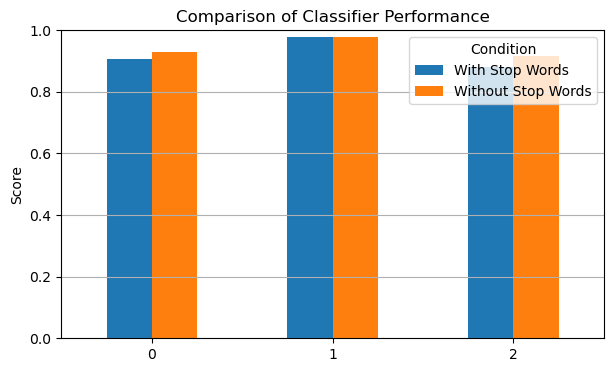

In [42]:
# plotting the values for better visualization
results_comparison.plot(kind='bar', figsize=(7, 4))
plt.title('Comparison of Classifier Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Condition')
plt.show()

As we can see above, the performance of our classifier when stop words are removed is higher compared when the stop words are included. From this, we can infer that removing the stop words can improve the performance of the model or classifier.

<b>2. Experiment on the number of words used for training to include words occurring 50, 100, and 1000 times¶</b>

In this part, we will filter the word list based on their frequency of occurrence. We will use varying thresholds where k = [1000, 100, 50]. The process is just the same as the above but I will be simplifying it here to make it shorter.

In [70]:
# we will use the first main dataframe we have, the one without stopwords
df_main

,file_path,label,cleaned_message
0,../data/000/000,0,mailing list queried weeks ago running set arc...
1,../data/000/001,1,luxury watches buy rolex rolex cartier bvlgari...
2,../data/000/002,1,academic qualifications prestigious nonacc red...
3,../data/000/003,0,greetings verify subscription planfans list ch...
4,../data/000/004,1,chauncey conferred luscious continued tonsillitis
...,...,...,...
37817,../data/126/017,1,great news expec ted infinex ventures infx pri...
37818,../data/126/018,1,oil sector going crazy weekly gift kkpt thing ...
37819,../data/126/019,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,../data/126/020,1,prosperous future increased money earning powe...


In [71]:
# define thresholds for filtering
thresholds = [1000, 100, 50]

# initialize a dictionary to store results for each threshold
results = {}

In [72]:
# splitting the data again
# test set
df_test = df_main[df_main['file_path'] >= '../data/071']

# general train set
df_train = df_main[df_main['file_path'] < '../data/071']

# for train set of spam
df_train_spam = df_train[df_train['label'] == 1]
df_train_spam = df_train_spam.reset_index()

# for train set of ham
df_train_ham = df_train[df_train['label'] == 0]
df_train_ham = df_train_ham.reset_index()

In [73]:
# we'll get the unique words from the cleaned messages without stopwords
# combine messages from the entire df_train dataset
all_words = []

# process all messages in df_train
for msg in df_train['cleaned_message']:
    all_words.extend(msg.split())

# count occurrences of each word
word_counts = Counter(all_words)

# get the 10,000 most common words and their frequencies
most_common_words = word_counts.most_common(10000)

# convert to a dataframe
df_unique_words = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

df_unique_words

,word,frequency
0,bb,17268
1,td,12030
2,will,11941
3,width,8226
4,size,5363
...,...,...
9995,httpwwwretsiunetptwwwukrnet,21
9996,hrefhttpwwwretsiunetptampwwwukrnetfont,21
9997,emulator,21
9998,caring,21


In [74]:
for threshold in thresholds:
    # filter the unique words based on the threshold
    filtered_words = df_unique_words[df_unique_words['frequency'] >= threshold]['word'].tolist()
    V_filtered = len(filtered_words)  # number of unique words after filtering

    # create new feature matrices for spam and ham with filtered words
    matrix_spam_filtered = np.zeros((num_spam, V_filtered), dtype=int)
    matrix_ham_filtered = np.zeros((num_ham, V_filtered), dtype=int)

    # create a mapping from filtered words to indices
    word_index_filtered = {word: i for i, word in enumerate(filtered_words)}

    # fill the feature matrices using the filtered words
    fill_feature_matrix(df_train_spam, matrix_spam_filtered, word_index_filtered, 'cleaned_message')
    fill_feature_matrix(df_train_ham, matrix_ham_filtered, word_index_filtered, 'cleaned_message')

    # count words in ham and spam classes
    ham_word_count_filtered = np.sum(matrix_ham_filtered, axis=0)
    spam_word_count_filtered = np.sum(matrix_spam_filtered, axis=0)

    # total words in ham and spam classes
    ham_word_total_filtered = np.sum(ham_word_count_filtered)
    spam_word_total_filtered = np.sum(spam_word_count_filtered)

    # calculate probabilities with Laplace smoothing for filtered words
    ham_probabilities_filtered = {}
    spam_probabilities_filtered = {}

    for word in filtered_words:
        temp_ham = (ham_word_count_filtered[word_index_filtered[word]] + a) / (ham_word_total_filtered + a * V_filtered)
        temp_spam = (spam_word_count_filtered[word_index_filtered[word]] + a) / (spam_word_total_filtered + a * V_filtered)
        
        ham_probabilities_filtered[word] = temp_ham
        spam_probabilities_filtered[word] = temp_spam

    # classify emails in the test set using the filtered probabilities
    predictions_filtered = []

    for message in df_test['cleaned_message']:
        prediction = classify_emails(message, p_ham, p_spam, ham_probabilities_filtered, spam_probabilities_filtered, filtered_words)
        predictions_filtered.append(prediction)

    # evaluate results
    accuracy = accuracy_score(df_test['label'], predictions_filtered)
    precision = precision_score(df_test['label'], predictions_filtered)
    recall = recall_score(df_test['label'], predictions_filtered)

    results[threshold] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [75]:
# display the results
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'Precision', 'Recall']
results_df

,Accuracy,Precision,Recall
1000,0.905641,0.927042,0.933453
100,0.931304,0.971342,0.925370
50,0.931062,0.975819,0.920521


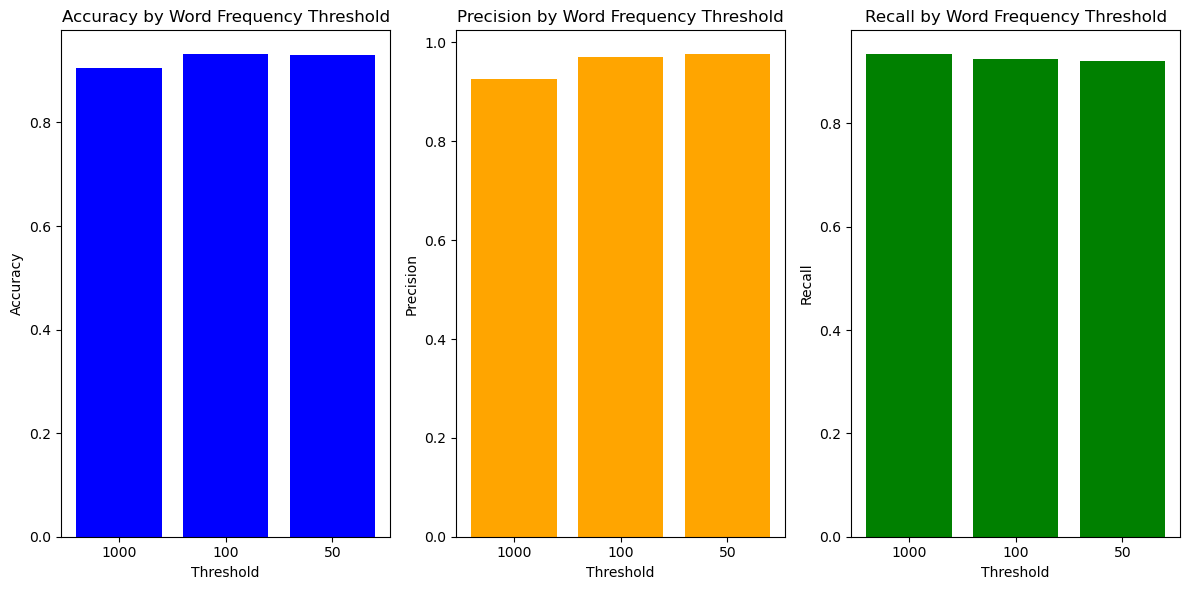

In [76]:
# plotting the performance metrics for better visualization
plt.figure(figsize=(12, 6))

# accuracy
plt.subplot(1, 3, 1)
plt.bar(results_df.index.astype(str), results_df['Accuracy'], color='blue')
plt.title('Accuracy by Word Frequency Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

# precision
plt.subplot(1, 3, 2)
plt.bar(results_df.index.astype(str), results_df['Precision'], color='orange')
plt.title('Precision by Word Frequency Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')

# recall
plt.subplot(1, 3, 3)
plt.bar(results_df.index.astype(str), results_df['Recall'], color='green')
plt.title('Recall by Word Frequency Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

Based on the result, it can be noted that lower threshold, such as 50 and 100, can improve the performance of the model compared to a higher threshold like 1000.

<b>3. Using different parameters for Lambda smoothing where = 2.0, 1.0, 0.5, 0.1, 0.005</b>

For this part, I will also be using the data where the stop words is not included.

In [77]:
# list of lambda values to test
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

evaluation_results = {}

In [78]:
for a in lambda_values:
    # calculate probabilities with Laplace smoothing for current lambda value
    ham_probabilities = {}
    spam_probabilities = {}

    for i in range(V):
        word = df_unique_words['word'][i]
        
        # P(w_i|ham) = (count(w_i,ham) + a) / (total words in ham + a * V)
        temp_ham = (ham_word_count[i] + a) / (ham_word_total + a * V)
        
        # P(w_i|spam) = (count(w_i,spam) + a) / (total words in spam + a * V)
        temp_spam = (spam_word_count[i] + a) / (spam_word_total + a * V)
        
        # assign probabilities to the respective dictionaries
        ham_probabilities[word] = temp_ham
        spam_probabilities[word] = temp_spam

    # initialize lists to store predictions
    predictions = []

    # classify each email in the test set using the current lambda value
    for message in df_test['cleaned_message']:
        prediction = classify_emails(message, p_ham, p_spam, ham_probabilities, spam_probabilities, df_unique_words['word'].tolist())
        predictions.append(prediction)

    # calculate evaluation metrics
    accuracy = accuracy_score(df_test['label'], predictions)
    precision = precision_score(df_test['label'], predictions)
    recall = recall_score(df_test['label'], predictions)

    # store results for the current lambda value
    evaluation_results[a] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

In [85]:
# create a list to store the results
results_list = []

# populate the list with results
for lambda_val, metrics in evaluation_results.items():
    results_list.append({
        'Lambda (λ)': lambda_val,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall']
    })

# convert the list into a DataFrame
results_df = pd.DataFrame(results_list)

# display the DataFrame
results_df

,Lambda (λ),Accuracy,Precision,Recall
0,2.000,0.538555,0.648306,0.689178
1,1.000,0.541520,0.648111,0.699506
2,0.500,0.540310,0.645416,0.705523
3,0.100,0.544849,0.643921,0.726269
4,0.005,0.553686,0.645426,0.749529


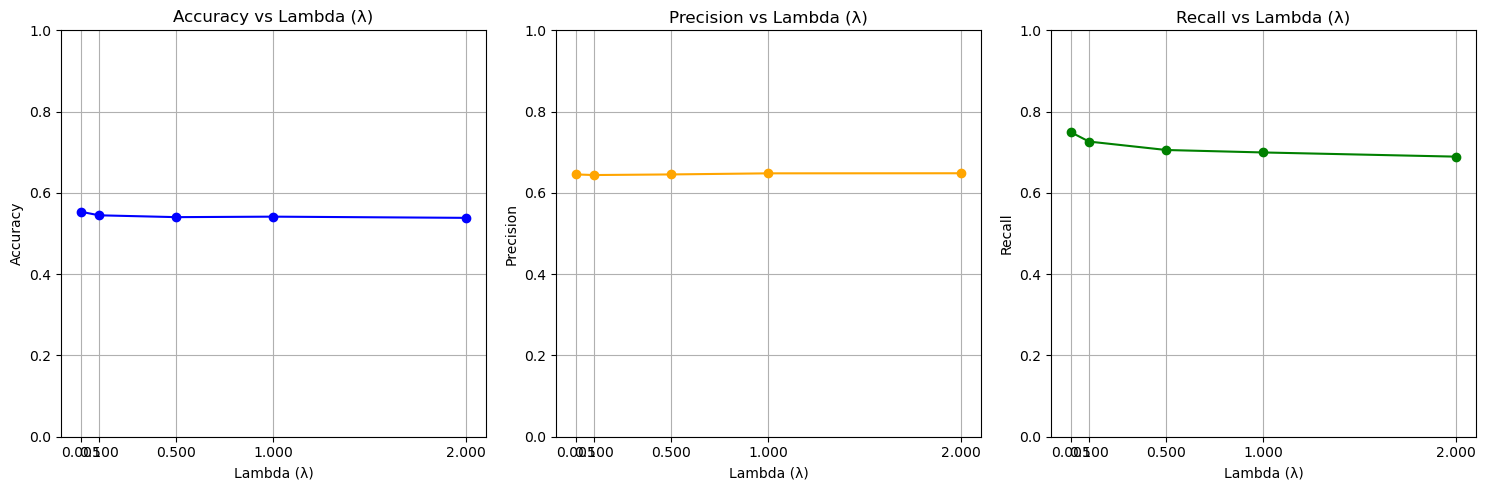

In [87]:
# Set the figure size
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.plot(results_df['Lambda (λ)'], results_df['Accuracy'], marker='o', color='blue')
plt.title('Accuracy vs Lambda (λ)')
plt.xlabel('Lambda (λ)')
plt.ylabel('Accuracy')
plt.xticks(results_df['Lambda (λ)'])  # Show lambda values on x-axis
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.grid(True)

# Plot Precision
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.plot(results_df['Lambda (λ)'], results_df['Precision'], marker='o', color='orange')
plt.title('Precision vs Lambda (λ)')
plt.xlabel('Lambda (λ)')
plt.ylabel('Precision')
plt.xticks(results_df['Lambda (λ)'])  # Show lambda values on x-axis
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.plot(results_df['Lambda (λ)'], results_df['Recall'], marker='o', color='green')
plt.title('Recall vs Lambda (λ)')
plt.xlabel('Lambda (λ)')
plt.ylabel('Recall')
plt.xticks(results_df['Lambda (λ)'])  # Show lambda values on x-axis
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.grid(True)

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Based from the results, we can see that lower values of lambda can make the model's performance better than higher values of lambda. However, it is important to note that there are some trade offs such as, when the precision is higher the accuracy and recall is lower.

<b>4. Recommendations to improve the model</b>

Based from the results of experimentations, removing nonsensical words can really improve the performance of the classifier in terms of accuracy, precision, and recall.This improvement can be attributed to the fact that the model can focus more on relevant features from the data, allowing it to learn more effectively. Additionally, using smaller number of vocabulary or words can lead to a better model performance. By limiting the number of words, for example 50, we reduce noise, allowing the classifier to concentrate on relevant features. Moreover, employing lower values of the lambda for Laplace smoothing can also positively impact the model's performance. In summary, we can follow these strategies - removing nonsensical words, using smaller number of words and lower values of lambda to further improve the overall performance of the model.